### *** Importing Packages ***

In [ ]:
import numpy as np
import pandas as pd
import re
import time
from typing import List
from io import open
import unicodedata
import random
import glob
import json
import sys
import os
import nltk
from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense, Bidirectional
from __future__ import unicode_literals, print_function, division
from keras.models import Model, load_model

INPUT_LENGTH = 20
OUTPUT_LENGTH = 20

### *** Reading Dataset ***

In [ ]:
# Reading the dataset
df = pd.read_csv("final_faq.csv")
df.tail(10)

,Context,Answer
469,How long is the incubation period for COVID-19?,The “incubation period” means the time between...
470,What is the state doing to protect our health? \n,California has been actively and extensively p...
471,What is SARS-CoV-2? What is COVID-19?,Severe Acute Respiratory Syndrome Coronavirus-...
472,Where do coronaviruses come from?,Coronaviruses are viruses that circulate among...
473,Is this virus comparable to SARS or to the sea...,The novel coronavirus detected in China is gen...
474,How severe is COVID-19 infection?,Preliminary findings indicate that the mortali...
475,What is the mode of transmission? How (easily)...,While animals are the original source of the v...
476,What are the symptoms ofÂ COVID-19 infection,"The virus can cause mild, flu-like symptoms su..."
477,Are some people more at risk than others?,Generally elderly people and those with underl...
478,Are children also at risk of infection?,Disease in children appears to be relatively r...


In [ ]:
# Creating QA Lists
questions = list(df['Context']);question.append("Hello");question.append("How are you ?");question.append("Bye");
answers = list(df['Answer']);answer.append("Hi, I am Covid-Bot");answer.append("I am Fine, How can I help u");answer.append("Good Bye");

### *** Text Preprocessing ***

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"who's","who is",text) 
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)  
    text = re.sub(r"[-()\"#/@;:<>{}+=~|.?,]","",text) 
    text = " ".join(text.split())
    return text

In [ ]:
# Cleaning the QA Lists 
clean_questions = []
for question in questions:
    clean_questions.append(clean_text(question))
clean_answers = []    
for answer in answers:
    clean_answers.append(clean_text(answer))

In [ ]:
lengths = []
#nltk method
for question in clean_questions:
    lengths.append(len(question.split()))
for answer in clean_answers:
    lengths.append(len(answer.split()))
# Create a dataframe
lengths = pd.DataFrame(lengths, columns=['counts'])

In [ ]:
lengths

,counts
0,4
1,4
2,3
3,6
4,6
...,...
953,36
954,167
955,35
956,30


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### *** Tokenizing the Question and Answer lists ***

In [ ]:
#tokenizing Q & A (Using ntlk)
Q_tok = [nltk.word_tokenize(sent) for sent in questions]
A_tok = [nltk.word_tokenize(sent) for sent in answers]

In [ ]:
# Tokenizing means :
# "This is a cooool #smiley: :-) :-P <3 and some arrows < > -> <--"
# ['This', 'is', 'a', 'cooool', '#smiley', ':', ':-)', ':-P', '<3', 'and', 'some', 'arrows', '<', '>', '->', '<--']

In [ ]:
#train-validation split
data_size = len(Q_tok)

# 80 % training 20 % validation
training_input  = Q_tok[:round(data_size*(80/100))]
training_input  = [tr_input[::-1] for tr_input in training_input] #reversing input seq for better performance
training_output = A_tok[:round(data_size*(80/100))]

validation_input = Q_tok[round(data_size*(80/100)):]
validation_input  = [val_input[::-1] for val_input in validation_input] #reversing input seq for better performance
validation_output = A_tok[round(data_size*(80/100)):]

### *** Building Vocabulary ***



In [ ]:
vocab = {}
for question in Q_tok:
    for word in question:
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1

for answer in A_tok:
    for word in answer:
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1    

In [ ]:
threshold = 15
count = 0
for k,v in vocab.items():
    if v >= threshold:
        count += 1

In [ ]:
WORD_CODE_START = 1
WORD_CODE_PADDING = 0
word_num  = 2
encoding = {}
decoding = {1: 'START'}
for word, count in vocab.items():
    if count >= threshold:  #get vocabularies that appear above threshold count
        encoding[word] = word_num  # Dictionary
        decoding[word_num ] = word  # Reverse Dictionary
        word_num += 1

No. of vocab used: 453


In [ ]:
decoding[len(encoding)+2] = '<UNK>'    # UNK means not in vocab
encoding['<UNK>'] = len(encoding)+2
dict_size = word_num+1

### *** Transforming textual data into vectors ***

In [ ]:
def transform(encoding, data, vector_size=20):
    transformed_data = np.zeros(shape=(len(data), vector_size))
    for i in range(len(data)):
        for j in range(min(len(data[i]), vector_size)):
            try:
                transformed_data[i][j] = encoding[data[i][j]]
            except:
                transformed_data[i][j] = encoding['<UNK>']
    return transformed_data

In [ ]:
#encoding training set
encoded_training_input = transform(
    encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = transform(
    encoding, training_output, vector_size=OUTPUT_LENGTH)

In [ ]:
encoded_validation_input = transform(
    encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = transform(
    encoding, validation_output, vector_size=OUTPUT_LENGTH)

### *** Building Seq2Seq Model ***

In [ ]:
#Here i have just written this code to display the video on colab
from IPython.display import HTML
data_url = "https://user-images.githubusercontent.com/66860602/126584866-17390df8-1933-4c57-a90f-5cf5a355de60.mp4"
HTML("""
<video width=900 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

***Seq 2 Seq model has various applications like text summarisation, translation and building chatbots. Here is an animation of how translation works. Similarly in our case chatbot is fed with question and it predict the output word by word.***

In [ ]:
#Here i have just written this code to display the video on colab
from IPython.display import HTML
data_url = "https://user-images.githubusercontent.com/66860602/126584869-6700998f-f0f8-4379-b45a-48cd9dcfd322.mp4"
HTML("""
<video width=900 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

***Visualizing Encoder and decoder working : Encoder gets a sequence on input i.e, Questions and it creates a context vector, which then passed to Decoder which predicts the output and shows the answer results.***

In [ ]:
from IPython.display import HTML
data_url = "https://user-images.githubusercontent.com/66860602/126584963-2f163bdc-1d68-410c-ba5c-883ec2c00009.mp4"
HTML("""
<video width=900 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
from keras.layers import SimpleRNN

encoder = Embedding(dict_size, 128, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = LSTM(512, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]
decoder = Embedding(dict_size, 128, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(512, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

***Understanding LSTM (Long short term memory):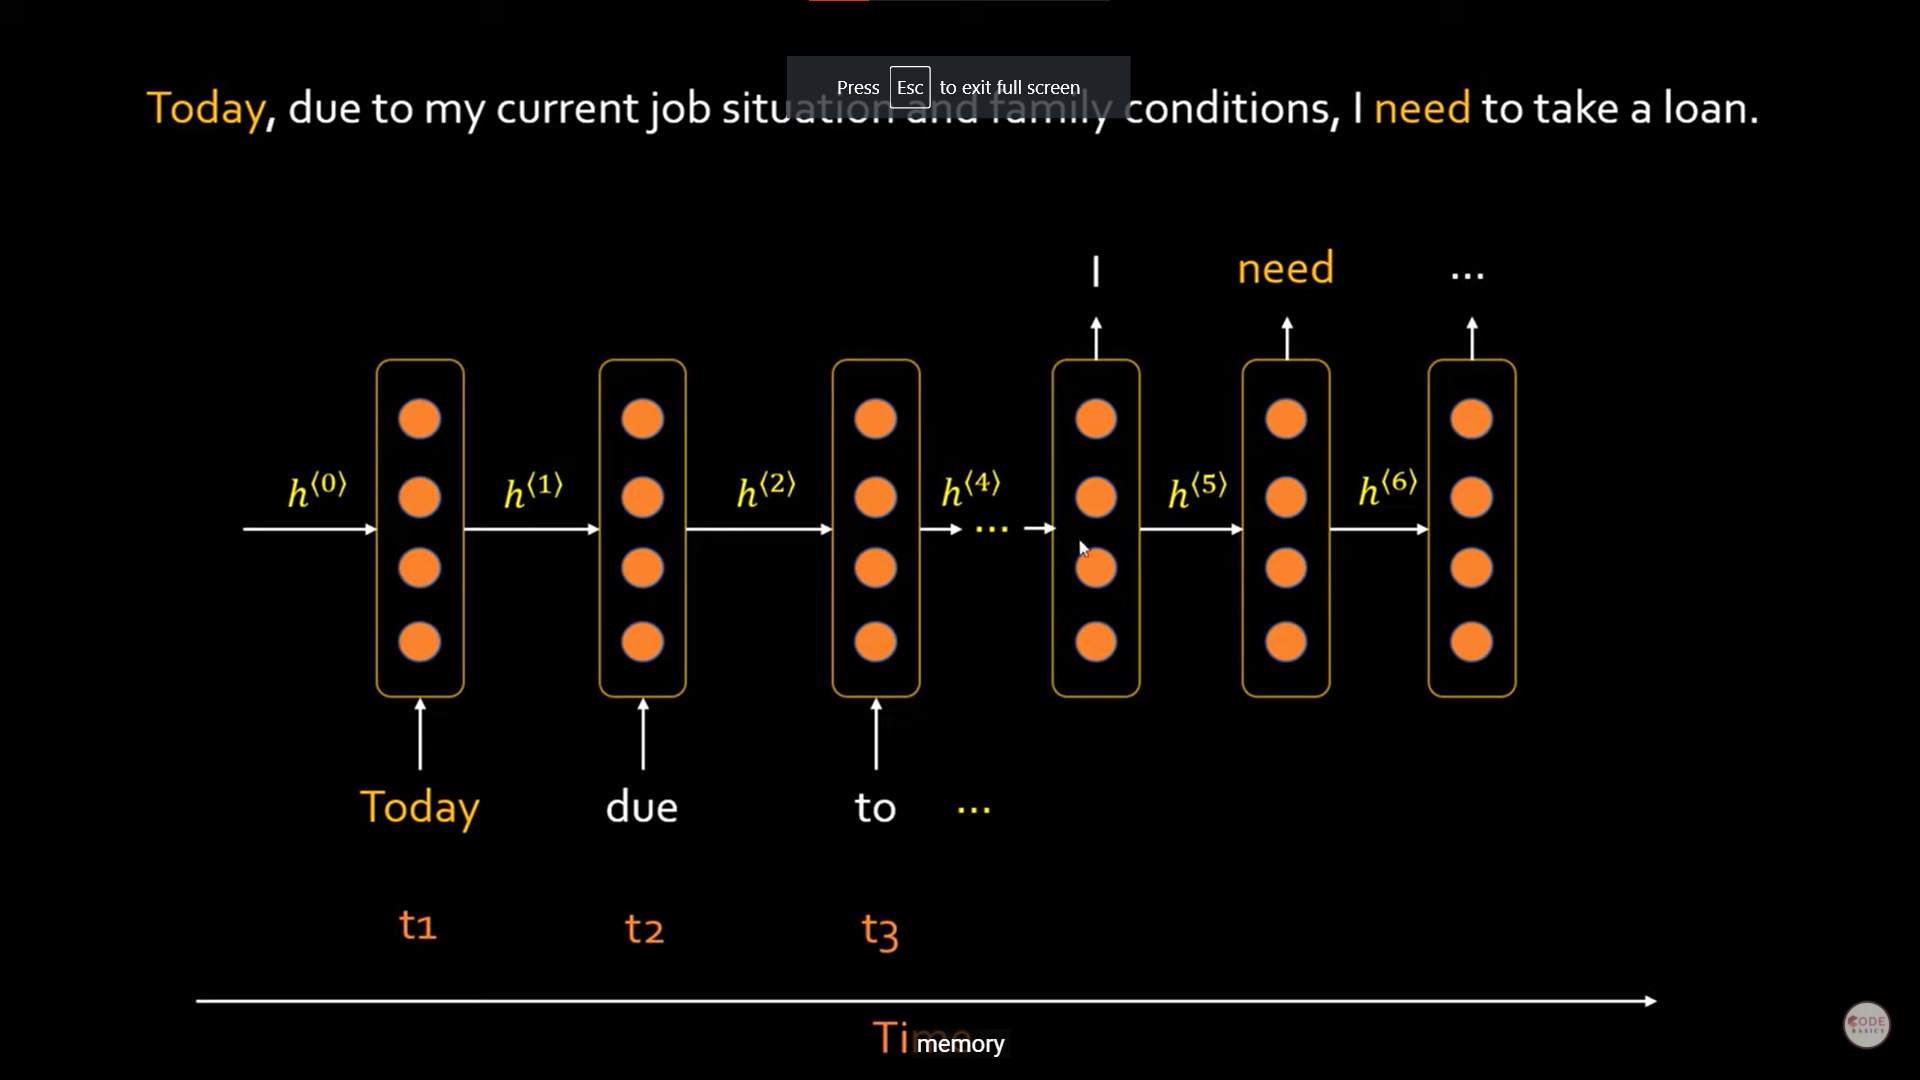***

Lets say we have two sentences :
1. **Today**, due to my current job situation and family condition, I need to **take** a loan.
2. **Last year**, due to my current job situation and family condition, I need to **had** a loan.

*Importance of LSTM layer* :

Traditional RNN works like we fed word by word and to predict "**take**" in sentence 1 it has a problem of short term memory.

Use of LSTM is very useful in case on any loss during training and testing of RNN layer because it helps RNN to predict the word like "**had**" in sentence 2.

In [ ]:
from keras.layers import Activation, dot, concatenate

attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
print('attention', attention)
context = dot([attention, encoder], axes=[2,1])
decoder_combined_context = concatenate([context, decoder])
output = TimeDistributed(Dense(512, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(dict_size, activation="softmax"))(output)
print('output', output)

attention KerasTensor(type_spec=TensorSpec(shape=(None, 20, 20), dtype=tf.float32, name=None), name='attention/Softmax:0', description="created by layer 'attention'")
output KerasTensor(type_spec=TensorSpec(shape=(None, 20, 454), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


In [ ]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 128)      58112       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 20, 512)      1312768     embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = WORD_CODE_START
training_decoder_output = np.eye(dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = WORD_CODE_START
validation_decoder_output = np.eye(dict_size)[encoded_validation_output.astype('int')]

### *** Training the Model ***

In [ ]:
model.fit(x=[training_encoder_input, training_decoder_input], 
          y=[training_decoder_output],
          validation_data = ([validation_encoder_input, 
                              validation_decoder_input], 
                              [validation_decoder_output]),
                              #validation_split=0.05,
                              batch_size=64, 
                              epochs=200)

model.save('model_topic3.h5')

Epoch 1/200
6/6 [==============================] - 60s 2s/step - loss: 0.0153 - val_loss: 0.0155
Epoch 2/200
6/6 [==============================] - 6s 935ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 3/200
6/6 [==============================] - 6s 929ms/step - loss: 0.0143 - val_loss: 0.0136
Epoch 4/200
6/6 [==============================] - 6s 938ms/step - loss: 0.0128 - val_loss: 0.0133
Epoch 5/200
6/6 [==============================] - 6s 942ms/step - loss: 0.0121 - val_loss: 0.0126
Epoch 6/200
6/6 [==============================] - 6s 930ms/step - loss: 0.0118 - val_loss: 0.0124
Epoch 7/200
6/6 [==============================] - 6s 943ms/step - loss: 0.0116 - val_loss: 0.0123
Epoch 8/200
6/6 [==============================] - 6s 943ms/step - loss: 0.0115 - val_loss: 0.0123
Epoch 9/200
6/6 [==============================] - 6s 934ms/step - loss: 0.0116 - val_loss: 0.0123
Epoch 10/200
6/6 [==============================] - 6s 933ms/step - loss: 0.0115 - val_loss: 0.0123
Epoch 11/20

### *** Saving the model to directly predict from it ***

In [ ]:
from keras import models
m = "final_chatbot_seq2seq_model.h5"
model_seq2seq = models.load_model(m)

In [ ]:
def prediction(raw_input):
    clean_input = clean_text(raw_input)
    input_tok = [nltk.word_tokenize(clean_input)]
    input_tok = [input_tok[0][::-1]]  #reversing input seq
    encoder_input = transform(encoding, input_tok, 20)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = WORD_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model_seq2seq.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return output

def decode(decoding, vector):
    text = ''
    for i in vector:
        if i == 0:
            break
        text += ' '
        text += decoding[i]
    return text

### *** Testing our Chatbot ***

In [ ]:
raw_input = input()
output = prediction(raw_input)
print (decode(decoding, output[0]))

What is corona?
 <UNK> are a large family of viruses which may cause illness in animals or <UNK>


In [ ]:
raw_input = input()
output = prediction(raw_input)
print (decode(decoding, output[0]))

How long does the virus survive on surfaces?
 CDC does not recommend that <UNK> travelers wear <UNK> to protect <UNK> from COVID-19 . <UNK> a <UNK> only only


In [ ]:
raw_input = input()
output = prediction(raw_input)
print (decode(decoding, output[0]))

What can I do to protect myself and prevent the spread of disease?
 <UNK> touching eyes , nose and mouth .
